In [614]:
import networkx as nx
import matplotlib.pyplot as plt
from numpy import genfromtxt
import numpy as np

from jupyterthemes import jtplot
jtplot.style(theme='oceans16', grid=False, figsize=(10, 6))
import os

np.set_printoptions(precision=3)
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

In [324]:
%load_ext autoreload
%autoreload 2
from net_flow import NetFlow, insert_front

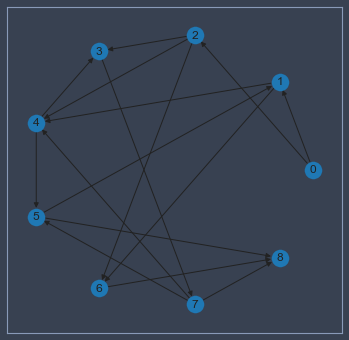

In [469]:
data_folder = 'data'
network_diagram1_path = os.path.join(data_folder, 'diagram1.csv')

custom_net = NetFlow(network_diagram1_path)
plt.figure(figsize=(6, 6))
custom_net.draw()

In [309]:
np.random.seed(233)
time_table = np.random.random(10) * 5

num = 10
samples = custom_net.sample(num, {0:0.5, 4:0.5}, 10)
print(time_table)
samples_set = [samples[np.random.randint(0, 10)].copy() for i in range(num * 10)]
samples_set[:10]

[0.747 4.461 2.916 4.499 1.745 0.742 0.592 2.133 3.628 4.803]


[[4, 3, 7, 8],
 [0, 1, 6, 8],
 [4, 5, 8],
 [4, 3, 7, 8],
 [4, 3, 7, 8],
 [0, 1, 6, 8],
 [4, 3, 7, 8],
 [4, 5, 1, 6, 8],
 [0, 2, 3, 7, 8],
 [4, 5, 1, 6, 8]]

### Benchmark

先到先得

In [597]:
def init_head_tasks(samples):
    head_tasks = {node_id:[] for node_id in custom_net.nodes_id}
    for i, sample in enumerate(samples):
        head_tasks[sample[0]].append(i)
    return head_tasks
        
def time_first_strategy(samples, time_table):
    def get_new_task(tasks, samples):
        has_task = False
        origin_head_tasks = {k:v.copy() for k, v in head_tasks.items()}
        for node_id, rows in origin_head_tasks.items():
            if rows:
                has_task = True
                if node_id not in tasks[-1]:
                    tasks[-1].append(node_id)
                    if temp_new_task != None:
                        temp_new_task.append(node_id)
                    # update the head_tasks
                    row = head_tasks[node_id].pop(0)
                    samples[row].pop(0)
                    # first come first do principle
                    if len(samples[row]):
                        new_node_id = samples[row][0]
                        insert_front(row, head_tasks[new_node_id])

        return has_task
            
    t = 0
    tasks, tasks_done, t_seqs = [[]], [], [0]
    head_tasks = init_head_tasks(samples)
    temp_new_task = None
    
    while get_new_task(tasks, samples):
        last_tasks =  tasks[-1]
        last_tasks_time = time_table[last_tasks] if t == 0 else np.hstack([last_tasks_time, 
                                                                           time_table[temp_new_task]])
        last_tasks_min_idx = last_tasks_time.argmin()
        
        last_tasks_min_time = last_tasks_time[last_tasks_min_idx]
        min_task_id = last_tasks[last_tasks_min_idx]
        # now we done, there may be some problem if two task have the same process time
        tasks_done.append([])
        tasks.append([])
        for task in last_tasks:
            tasks_done[-1].append(task) if task == min_task_id else tasks[-1].append(task)
        
        last_tasks_time = last_tasks_time[last_tasks_time != last_tasks_min_time] - last_tasks_min_time
        
        temp_new_task = []
        t += last_tasks_min_time
        
        t_seqs.append(t)
        
    return (tasks[:-1], t_seqs, tasks_done)
    
np.random.seed(233)
size = num * 100
samples_set = [samples[np.random.randint(0, 10)].copy() for i in range(size)]
tasks, t_seqs, tasks_done = time_first_strategy(samples_set, time_table)

In [598]:
def get_flatten_ls(multi_dls):
    return [num for one_dls in multi_dls for num in one_dls]
flatten_tasks_done = get_flatten_ls(tasks_done)

len(tasks_done), len(tasks), len(t_seqs)

(5120, 5120, 5121)

In [601]:
points_num = len(t_seqs)
all_node_id = set(custom_net.nodes_id)
tasks_time_seqs = np.array([np.zeros(points_num) for _ in all_node_id])

for i in range(1, points_num):
    tasks_set = set(tasks[i-1])
    t_diff = t_seqs[i] - t_seqs[i-1]
    for node_id in tasks_set:
        tasks_time_seqs[node_id][i] = t_diff + tasks_time_seqs[node_id][i-1]
    for other_node_id in (all_node_id - tasks_set):
        tasks_time_seqs[other_node_id][i] = tasks_time_seqs[other_node_id][i-1]

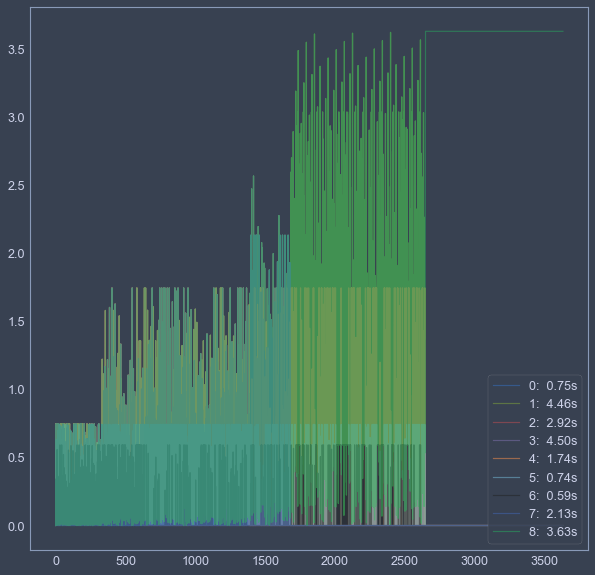

In [602]:
plt.figure(figsize=(10, 10))
diff_tasks_time_seqs = tasks_time_seqs.copy()
diff_tasks_time_seqs[:, 1:] = tasks_time_seqs[:, 1:] - tasks_time_seqs[:, :-1]

for node_id in all_node_id:
    plt.plot(t_seqs, diff_tasks_time_seqs[node_id], 
             alpha=0.5, label=f"{node_id}:  {time_table[node_id]:.2f}s")
plt.legend(loc="lower right")

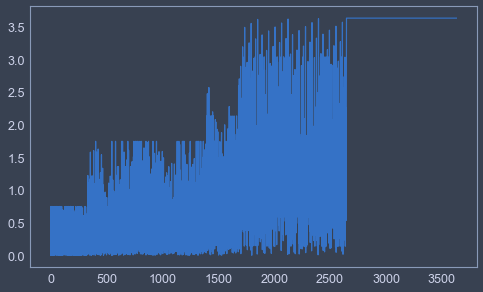

In [604]:
plt.plot(t_seqs, diff_tasks_time_seqs[8], label=f"{node_id}:  {time_table[node_id]:.2f}s")

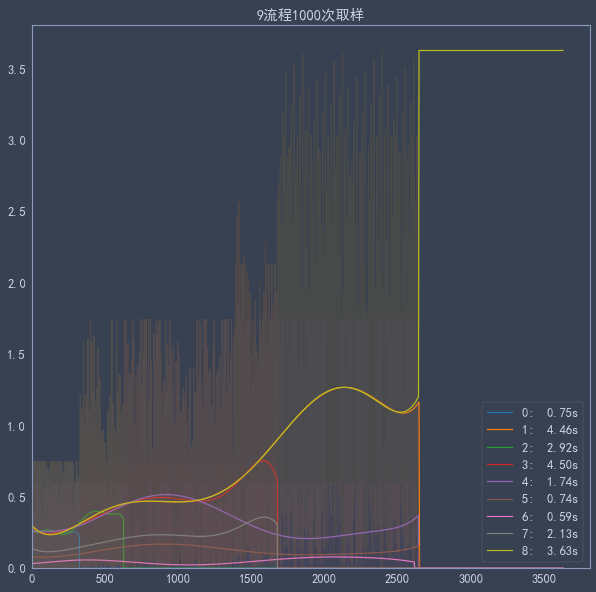

In [617]:
colors = plt.get_cmap('tab20').colors
plt.figure(figsize=(10, 10))
for node_id in list(all_node_id):
    color = colors[node_id * 2]
    exclude_idxs = diff_tasks_time_seqs[node_id].cumsum().argmax() + 3 if node_id != 8 else \
                    np.around(diff_tasks_time_seqs[node_id], 4).argmax()
    
    weight = np.polyfit(t_seqs[:exclude_idxs], diff_tasks_time_seqs[node_id][:exclude_idxs], 7)
    fit_diff_tasks_time_seqs = np.poly1d(weight)(t_seqs[:exclude_idxs])
    plt.plot(t_seqs, np.hstack([fit_diff_tasks_time_seqs, diff_tasks_time_seqs[node_id][exclude_idxs:]]), 
            label=f"{node_id}:  {time_table[node_id]:.2f}s", color=color) 
    plt.plot(t_seqs, diff_tasks_time_seqs[node_id], alpha=0.05, color=color)

title = f"{custom_net.node_num}流程{size}次取样"
plt.title(title)
plt.legend(loc="lower right")
plt.ylim(0, )
plt.xlim(0,)
plt.savefig(fname=f"graph/{title}", dpi=200)

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [393]:
# test = {0:[], 1:[]}
# test[0].append(1)
# test
test = np.array([1.8, 1.2, 1.1, 5])
# test -= 1.1
np.hstack([test, test])

array([1.800, 1.200, 1.100, 5.000, 1.800, 1.200, 1.100, 5.000])

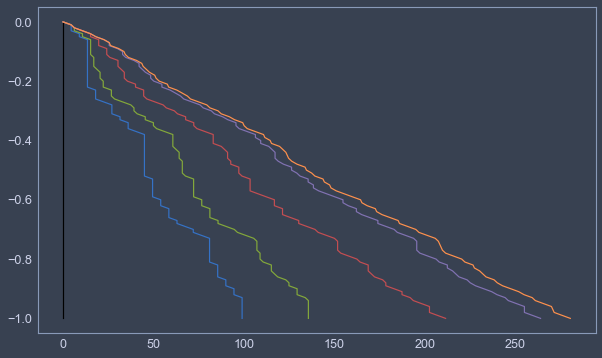

In [261]:
np.random.seed(233)
size = 100
time_axis = np.linspace(0, 1, size+1)
init_time_seq = np.zeros(size+1)

time_table = np.random.random(5) * 5
nodes_id = np.array(range(5))
nodes_id_seq = np.random.choice(nodes_id, size=size)

nodes_id_by_idxs, first_idxs = np.unique(nodes_id_seq, return_index=True)
sorted_nodes_id = nodes_id_by_idxs[np.argsort(first_idxs)]

plt.figure(figsize=(10, 6))
time_cumsum = init_time_seq.copy()
plt.plot(time_cumsum, -time_axis, color='black')
for node_id in sorted_nodes_id:
    time_seq = init_time_seq.copy()
    time_seq[np.where(nodes_id_seq == node_id)[0] + 1] = time_table[node_id]
    time_cumsum += time_seq.cumsum()
    plt.plot(time_cumsum, -time_axis)

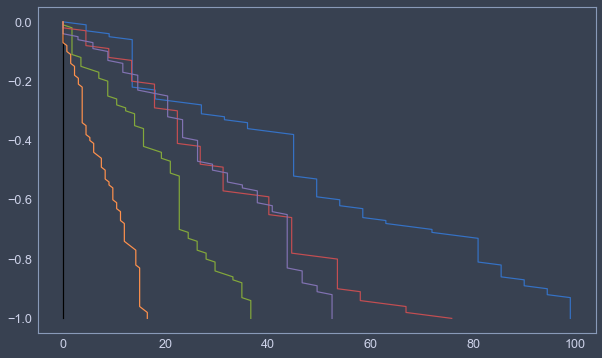

In [265]:
plt.figure(figsize=(10, 6))
time_cumsum = init_time_seq.copy()
plt.plot(time_cumsum, -time_axis, color='black')
for node_id in sorted_nodes_id:
    time_seq = init_time_seq.copy()
    time_seq[np.where(nodes_id_seq == node_id)[0] + 1] = time_table[node_id]
    time_cumsum += time_seq.cumsum()
    plt.plot(time_seq.cumsum(), -time_axis)

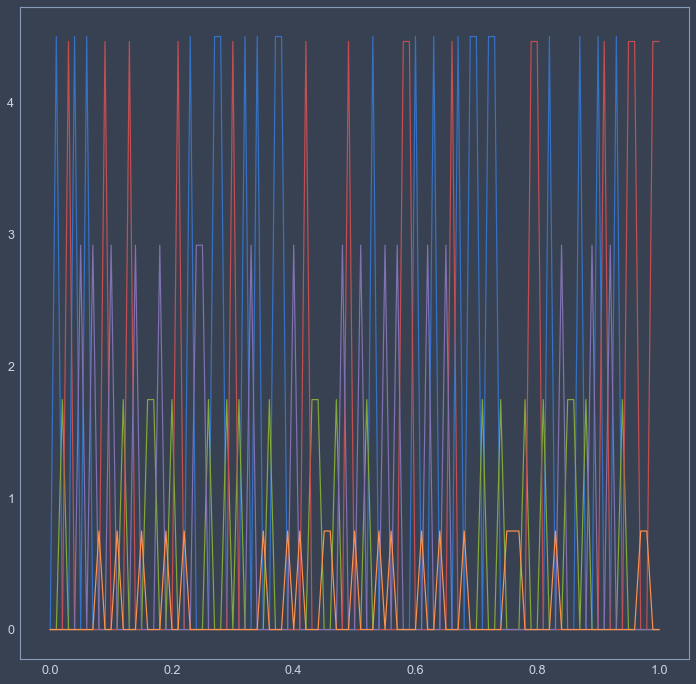

In [262]:
plt.figure(figsize=(12, 12))
time_cumsum = init_time_seq.copy()
# plt.plot(time_cumsum, -time_axis, color='black')
for node_id in sorted_nodes_id:
    time_seq = init_time_seq.copy()
    time_seq[np.where(nodes_id_seq == node_id)[0] + 1] = time_table[node_id]
    time_cumsum += time_seq.cumsum()
    plt.plot(time_axis, time_seq)

In [237]:
sorted_nodes_id, time_table

(array([3, 4, 1, 2, 0]), array([0.747, 4.461, 2.916, 4.499, 1.745]))

In [ ]:
np.array([1,2,3,0])

In [48]:
data_folder = 'data'
network_diagram1_path = os.path.join(data_folder, 'diagram1.csv')

graph_data = genfromtxt(network_diagram1_path, delimiter=',', dtype='int')
node_id = np.unique(graph_data)
node_num = len(node_id)

In [49]:
graph_matrix = np.zeros((node_num, node_num))

row_id, col_id = (graph_data - 1).T
graph_matrix[row_id, col_id] = 1

row_sum = graph_matrix.sum(axis=1)[:, None]
graph_matrix = np.divide(graph_matrix, row_sum, where=row_sum!=0)
print(graph_matrix)

[[0.000 0.500 0.500 0.000 0.000 0.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.500 0.000 0.500 0.000 0.000]
 [0.000 0.000 0.000 0.333 0.333 0.000 0.333 0.000 0.000]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 0.000]
 [0.000 0.000 0.000 0.500 0.000 0.500 0.000 0.000 0.000]
 [0.000 0.500 0.000 0.000 0.000 0.000 0.000 0.000 0.500]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 0.000 0.333 0.333 0.000 0.000 0.333]
 [0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000]]


In [45]:
list(zip(*bag.items()))

[(0, 1, 2), (0.2, 0.6, 0.2)]

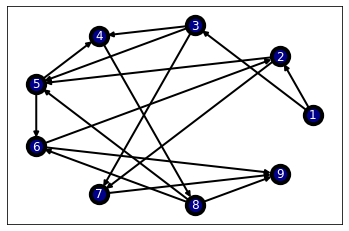

In [60]:
G = nx.DiGraph()
G.add_nodes_from(node_id)
G.add_edges_from(graph_data.tolist())
pos = nx.circular_layout(G)
#  neato, dot, twopi, circo, fdp, nop, wc, acyclic, gvpr, gvcolor, ccomps, sccmap, tred, sfdp, unflatten.
options = {
    "font_size": 12,
    "font_color": 'white',
    "node_size": 300,
    "node_color": "darkblue",
    "edgecolors": "black",
    "linewidths": 4,
    "width": 2,
}

nx.draw_networkx(G, pos=pos, **options)